# Train a reinforcement model that follows the line

First we import the necessary simulator libraries
- CarModel: a simulated car
- CanvasModel: a simulated training ground where the car can follow a line
- SimulatorControl: an environment where we can simulate actions like driving forward or turning left and right and read out new sensor values

In [1]:
import logging
import Car
import Canvas
import RobotCarSimulator

In [2]:
car = Car.CarModel()
# the seed controls the curve/line that we are following
canvas = Canvas.CanvasModel(seed=11)
# we set createGif to False to save space and runtime - we will generate the video once we apply the trained model
sim = RobotCarSimulator.SimulatorControl(canvas, car, createGif=False)

Model hyperparameters

In [3]:
GAMMA = 0.995             # discount factor
ALPHA = 1e-2              # learning rate  
TAU = 1e-2                # soft update
NUM_STEPS_FOR_UPDATE = 4  # perform a learning update every C time steps
MEMORY_SIZE = 100_000     # size of memory buffer
MINIBATCH_SIZE = 64   # mini-batch size
E_DECAY = 0.995       # ε decay rate for ε-greedy policy
E_MIN = 0.01          # minimum ε value for ε-greedy policy

## Action space

- 0 - driveForward(100,150)
- 1 - turnLeft(100,50)
- 2 - turnRight(100,50)

In [4]:
def driveForward():
    global sim
    sim.driveForward(100,150)

def turnLeft():
    global sim
    sim.turnLeft(100,50)
    
def turnRight():
    global sim
    sim.turnRight(100,50)
    
actions = (driveForward, turnLeft, turnRight)

num_actions = len(actions)

#to invoke action 0:
#actions[0]()

## Observation space

the observation space is only the sensor values of the 3 infrared sensors and the time exceeded (duration)

In [16]:
import numpy as np

def getReward():
    global sim
    return sim.getReward()

def getSensors():
    global sim
    return sim.getLineTrackingSensorValues()

def getDuration():
    global sim
    return sim.getDuration()

def isDone():
    global sim
    return sim.isTerminated()


# run one step and return next state (sensors), reward, done and time exceeded
def step(action):
    action()
    return (np.array(getSensors()), isDone(), getReward(), getDuration())
    
next_state, done, reward, duration = step(actions[0])     
    
state_size = 3 # we have three sensors

print(next_state, done, reward, duration) 

[ 30.         146.91333487 900.        ] False 20.0 0.25


# Deep Q-learning (reinforcement learning)

as learned in the coursera course we will use two models, the Q and target Q' networks (Deep Q Network) DQN.

In [17]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam
from collections import deque, namedtuple # for experience replay
import numpy as np
import random

In [18]:
# Create the Q-Network
q_network = Sequential([
    ### START CODE HERE ### 
    Input(shape=state_size),                      
    Dense(units=64, activation='relu'),            
    Dense(units=64, activation='relu'),            
    Dense(units=num_actions, activation='linear'),
    ### END CODE HERE ### 
    ])

# Create the target Q^-Network
target_q_network = Sequential([
    ### START CODE HERE ### 
    Input(shape=state_size),                      
    Dense(units=64, activation='relu'),            
    Dense(units=64, activation='relu'),            
    Dense(units=num_actions, activation='linear'),
    ### END CODE HERE ###
    ])


optimizer = Adam(learning_rate=ALPHA)           


2022-08-22 14:30:44.214297: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-22 14:30:44.214541: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


## Experience replay 

The coursera course recommends to use experience replay to avoid problematic correlations, oscillations and instabilities. In addition, experience replay also allows the agent to potentially use the same experience in multiple weight updates, which increases data efficiency.

In [19]:
# Store experiences as named tuples
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

In [20]:
# calculate_loss

def compute_loss(experiences, gamma, q_network, target_q_network):
    """ 
    Calculates the loss.
    
    Args:
      experiences: (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.
      q_network: (tf.keras.Sequential) Keras model for predicting the q_values
      target_q_network: (tf.keras.Sequential) Karas model for predicting the targets
          
    Returns:
      loss: (TensorFlow Tensor(shape=(0,), dtype=int32)) the Mean-Squared Error between
            the y targets and the Q(s,a) values.
    """
    
    # Unpack the mini-batch of experience tuples
    states, actions, rewards, next_states, done_vals = experiences
    
    # Compute max Q^(s,a)
    max_qsa = tf.reduce_max(target_q_network(next_states), axis=-1)
    
    # Set y = R if episode terminates, otherwise set y = R + γ max Q^(s,a).
    ### START CODE HERE ### 
    y_targets = rewards + (gamma * max_qsa * (1 - done_vals))
    ### END CODE HERE ###
    
    # Get the q_values
    q_values = q_network(states)
    q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]),
                                                tf.cast(actions, tf.int32)], axis=1))
        
    # Compute the loss
    ### START CODE HERE ### 
    loss = MSE(y_targets, q_values)
    ### END CODE HERE ### 
    
    return loss

In [21]:
def update_target_network(q_network, target_q_network):
    for target_weights, q_net_weights in zip(target_q_network.weights, q_network.weights):
        target_weights.assign(TAU * q_net_weights + (1.0 - TAU) * target_weights)

In [22]:
@tf.function
def agent_learn(experiences, gamma):
    """
    Updates the weights of the Q networks.
    
    Args:
      experiences: (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.
    
    """
    
    # Calculate the loss
    with tf.GradientTape() as tape:
        loss = compute_loss(experiences, gamma, q_network, target_q_network)

    # Get the gradients of the loss with respect to the weights.
    gradients = tape.gradient(loss, q_network.trainable_variables)
    
    # Update the weights of the q_network.
    optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))

    # update the weights of target q_network
    update_target_network(q_network, target_q_network)

In [23]:
def get_action(q_values, epsilon=0):
    if random.random() > epsilon:
        return np.argmax(q_values.numpy()[0])
    else:
        return random.choice(np.arange(num_actions))

In [24]:
def check_update_conditions(t, num_steps_upd, memory_buffer):
    if (t + 1) % num_steps_upd == 0 and len(memory_buffer) > MINIBATCH_SIZE:
        return True
    else:
        return False

In [25]:
def get_experiences(memory_buffer):
    experiences = random.sample(memory_buffer, k=MINIBATCH_SIZE)
    states = tf.convert_to_tensor(np.array([e.state for e in experiences if e is not None]),dtype=tf.float32)
    actions = tf.convert_to_tensor(np.array([e.action for e in experiences if e is not None]), dtype=tf.float32)
    rewards = tf.convert_to_tensor(np.array([e.reward for e in experiences if e is not None]), dtype=tf.float32)
    next_states = tf.convert_to_tensor(np.array([e.next_state for e in experiences if e is not None]),dtype=tf.float32)
    done_vals = tf.convert_to_tensor(np.array([e.done for e in experiences if e is not None]).astype(np.uint8),
                                     dtype=tf.float32)
    return (states, actions, rewards, next_states, done_vals)

In [26]:
def get_new_eps(epsilon):
    return max(E_MIN, E_DECAY*epsilon)

In [27]:
import time
start = time.time()

num_episodes = 2000
max_num_timesteps = 300

total_point_history = []

num_p_av = 100    # number of total points to use for averaging
epsilon = 1.0     # initial ε value for ε-greedy policy

# Create a memory buffer D with capacity N
memory_buffer = deque(maxlen=MEMORY_SIZE)

# Set the target network weights equal to the Q-Network weights
target_q_network.set_weights(q_network.get_weights())
# learn with 4 different curves to generalize the model and not optimize for a single curve
seeds = (2,5,9,11)

duration = 0.0

for i in range(num_episodes):
    
    # Reset the environment to the initial state and get the initial state
    car = Car.CarModel()
    # the seed controls the curve/line that we are following
    seed = seeds[i%len(seeds)]
    canvas = Canvas.CanvasModel(seed=seed)
    # we set createGif to False to save space and runtime - we will generate the video once we apply the trained model
    sim = RobotCarSimulator.SimulatorControl(canvas, car, createGif=False)
    state = np.array(getSensors())
    total_points = 0
    
    for t in range(max_num_timesteps):
        
        # From the current state S choose an action A using an ε-greedy policy
        state_qn = np.expand_dims(state, axis=0)  # state needs to be the right shape for the q_network
        q_values = q_network(state_qn)
        action = get_action(q_values, epsilon)
        
        # Take action A and receive reward R and the next state S'
        next_state, done, reward, duration = step(actions[action])   
       
        # Store experience tuple (S,A,R,S') in the memory buffer.
        # We store the done variable as well for convenience.
        memory_buffer.append(experience(state, action, reward, next_state, done))
        
        # Only update the network every NUM_STEPS_FOR_UPDATE time steps.
        update = check_update_conditions(t, NUM_STEPS_FOR_UPDATE, memory_buffer)
        
        if update:
            # Sample random mini-batch of experience tuples (S,A,R,S') from D
            experiences = get_experiences(memory_buffer)
            
            # Set the y targets, perform a gradient descent step,
            # and update the network weights.
            #print("\nUpdating model after ",t," steps")
            agent_learn(experiences, GAMMA)
        
        state = next_state.copy()
        total_points += reward
        
        if done:
            #print("\nBreaking episode ",i," after ",t," steps with reward ",total_points)
            break
            
    total_point_history.append(total_points)
    av_latest_points = np.mean(total_point_history[-num_p_av:])
    
    # Update the ε value
    epsilon = get_new_eps(epsilon)

    print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}", end="")

    if (i+1) % num_p_av == 0:
        print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")

    # We will consider that the environment is solved if we get an
    # average of 200 points in the last 100 episodes.
    if av_latest_points >= 20000.0:
        print(f"\n\nEnvironment solved in {i+1} episodes!")
        q_network.save('curve_tracking_model.h5')
        break
        
tot_time = time.time() - start

print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")
q_network.save('curve_tracking_model.h5')


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Episode 16 | Total point average of the last 100 episodes: -37817.50

KeyboardInterrupt: 

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

def plot_history(reward_history, rolling_window=20, lower_limit=None,
                 upper_limit=None, plot_rw=True, plot_rm=True):
    
    if lower_limit is None or upper_limit is None:
        rh = reward_history
        xs = [x for x in range(len(reward_history))]
    else:
        rh = reward_history[lower_limit:upper_limit]
        xs = [x for x in range(lower_limit,upper_limit)]
    
    df = pd.DataFrame(rh)
    rollingMean = df.rolling(rolling_window).mean()

    plt.figure(figsize=(10,7), facecolor='white')
    
    if plot_rw:
        plt.plot(xs, rh, linewidth=1, color='cyan')
    if plot_rm:
        plt.plot(xs, rollingMean, linewidth=2, color='magenta')

    text_color = 'black'
        
    ax = plt.gca()
    ax.set_facecolor('black')
    plt.grid()
#     plt.title("Total Point History", color=text_color, fontsize=40)
    plt.xlabel('Episode', color=text_color, fontsize=30)
    plt.ylabel('Total Points', color=text_color, fontsize=30)
    yNumFmt = mticker.StrMethodFormatter('{x:,}')
    ax.yaxis.set_major_formatter(yNumFmt)
    ax.tick_params(axis='x', colors=text_color)
    ax.tick_params(axis='y', colors=text_color)
    plt.show()
    

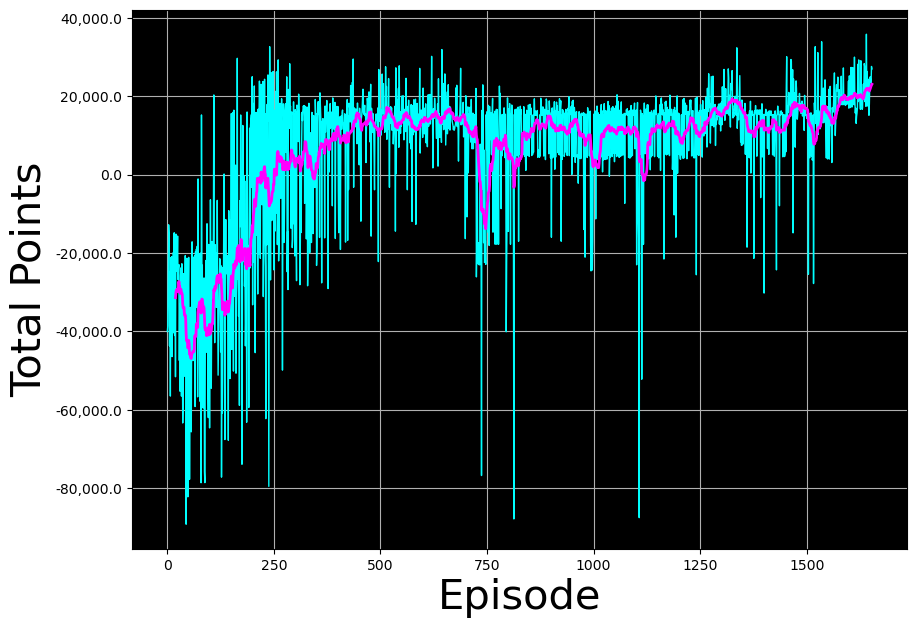

In [21]:
# Plot the point history
plot_history(total_point_history)

# Apply learned model and revisit results

In [29]:
import pprint
import sys
import logging
import Car
import Canvas
import RobotCarSimulator
import tensorflow as tf
from tensorflow.keras import Sequential
import numpy as np

model = tf.keras.models.load_model('curve_tracking_model.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 195       
Total params: 4,611
Trainable params: 4,611
Non-trainable params: 0
_________________________________________________________________


In [34]:
def driveForward():
    global sim
    sim.driveForward(100,150)

def turnLeft():
    global sim
    sim.turnLeft(100,50)
    
def turnRight():
    global sim
    sim.turnRight(100,50)
    
actions = (driveForward, turnLeft, turnRight)
seed=11


car = Car.CarModel()
# the seed controls the curve/line that we are following
canvas = Canvas.CanvasModel(seed=seed)
# we set createGif to False to save space and runtime - we will generate the video once we apply the trained model
sim = RobotCarSimulator.SimulatorControl(canvas, car, createGif=True)

while not sim.isTerminated() and sim.getDuration() < 20.0:
    state_qn = np.expand_dims(np.array(sim.getLineTrackingSensorValues()), axis=0)
    q_values = model(state_qn)
    action = np.argmax(q_values.numpy()[0])
    actions[action]()
    
sim.saveImage('model_seed_{}.gif'.format(seed))
with open('model_seed_{}.txt'.format(seed), 'w') as f:
    f.write("actions:\n")
    f.write(pprint.pformat(sim._actionLog))
    f.write("\n\npositions:\n")
    f.write(pprint.pformat(sim._carPositions))
    f.write("\n\norientations:\n")
    f.write(pprint.pformat(sim._carOrientations))